In [2]:
import torch
import os
import numpy as np
import random
import pandas as pd

from PIL import Image
from io import BytesIO
from base64 import b64decode

from timm import create_model
import torch.nn as nn
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset

import albumentations as A
from albumentations.pytorch import ToTensorV2

import tqdm.notebook as tq
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

/home/vivy/.local/lib/python3.12/site-packages/albumentations/check_version.py:49: UserWarning: Error fetching version info <urlopen error [Errno -3] Temporary failure in name resolution>
  data = fetch_version_info()


In [3]:
class MetricsDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        cell = self.df.iloc[idx]
        
        img = Image.open(BytesIO(b64decode(cell["photo"])))
        img = np.asarray(img.convert("RGB"))
        img = self.transform(image=img)["image"]
        
        target = cell["open_photo"] / cell["view"] if cell["view"] > 0 else 0

        return {
            "img" : img,
            "target" : target
        }

In [4]:
seed = 42
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

In [6]:
max_size = 224
transform = A.Compose([
    A.Resize(max_size, max_size),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2(transpose_mask=True),
])

class ConVNext(nn.Module):
    def __init__(self):
        super(ConVNext, self).__init__()
        self.image_model = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_efficientnet_b0', pretrained=True)
        self.image_model.classifier.fc = nn.Linear(in_features=1280, out_features=1, bias=True)
        self.answer = nn.Sigmoid()

    def forward(self, image_input):
        return self.answer(self.image_model(image_input))
df_path = "../../post2ctr_dataset.csv"
df = pd.read_csv(df_path)
train_df, test_df = train_test_split(df, test_size=0.2, random_state=seed)
test_dataset = MetricsDataset(test_df, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

In [31]:
model_path = "../../effnet_BCEWeighted_recsys.pth"

model = ConVNext()
model.load_state_dict(torch.load(model_path))


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

all_labels = []
all_preds = []
model.eval()
with torch.no_grad():
    loop = tq.tqdm(enumerate(test_loader), total=len(test_loader), leave=True, colour="steelblue")
    for batch_idx, data in loop:
        imgs = data["img"].to(device)
        labels = data["target"].to(device).squeeze()
        outputs = model(imgs).squeeze()
        
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(outputs.cpu().numpy())

Using cache found in /home/vivy/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub
/tmp/ipykernel_758/1119847865.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model

  0%|          | 0/589 [00:00<?, ?it/s]

Mean Absolute Error (MAE): 0.0394
Mean Squared Error (MSE): 0.0035
R² (coefficient of determination): -0.1944


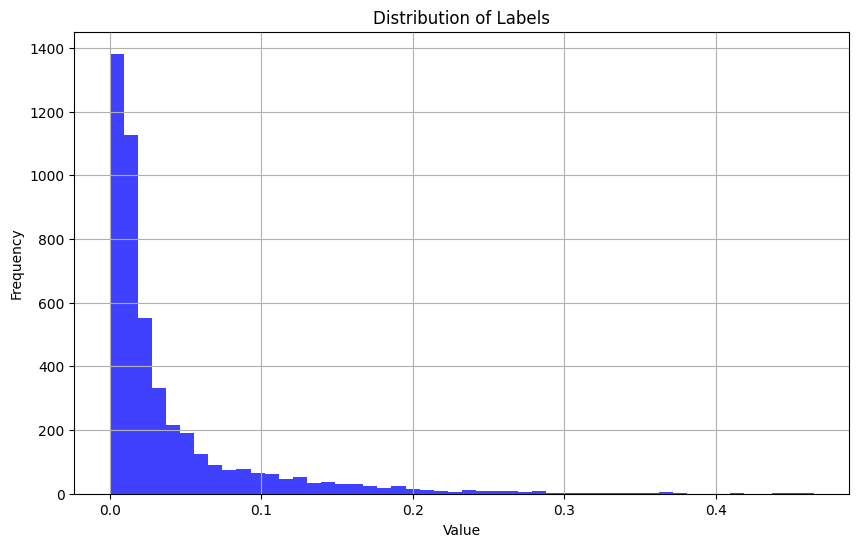

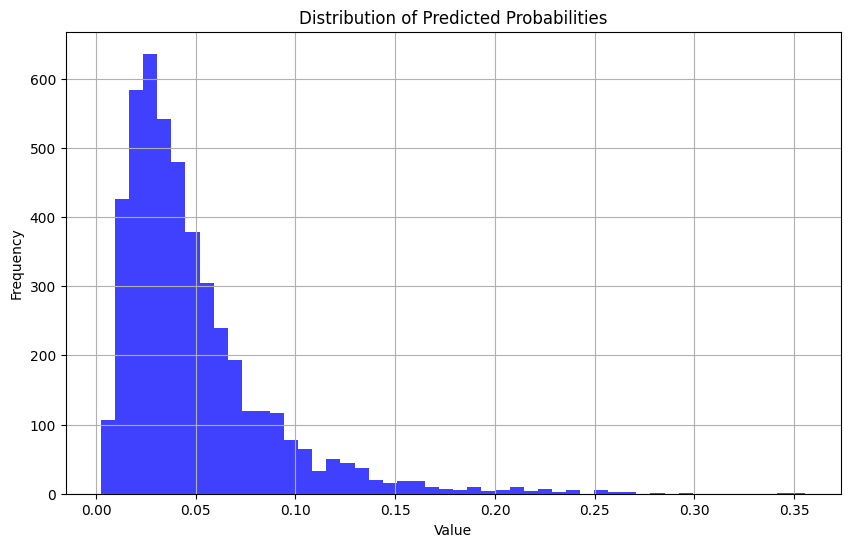

In [32]:
mae = mean_absolute_error(all_labels, all_preds)
mse = mean_squared_error(all_labels, all_preds)
r2 = r2_score(all_labels, all_preds)

print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"R² (coefficient of determination): {r2:.4f}")

plt.figure(figsize=(10, 6))
plt.hist(all_labels, bins=50, alpha=0.75, color='blue')
plt.title('Distribution of Labels')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.grid()
plt.show()

plt.figure(figsize=(10, 6))
plt.hist(all_preds, bins=50, alpha=0.75, color='blue')
plt.title('Distribution of Predicted Probabilities')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.grid()
plt.show()

In [8]:
model_path = "../../effnet_MSE_recsys.pth"

model = ConVNext()
model.load_state_dict(torch.load(model_path))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

all_labels_mse = []
all_preds_mse = []
model.eval()
with torch.no_grad():
    loop = tq.tqdm(enumerate(test_loader), total=len(test_loader), leave=True, colour="steelblue")
    for batch_idx, data in loop:
        imgs = data["img"].to(device)
        labels = data["target"].to(device).squeeze()
        outputs = model(imgs).squeeze()
        
        all_labels_mse.extend(labels.cpu().numpy())
        all_preds_mse.extend(outputs.cpu().numpy())

Using cache found in /home/vivy/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub
/tmp/ipykernel_758/4187090586.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model

  0%|          | 0/589 [00:00<?, ?it/s]

Mean Absolute Error (MAE): 0.0327
Mean Squared Error (MSE): 0.0027
R² (coefficient of determination): 0.0549


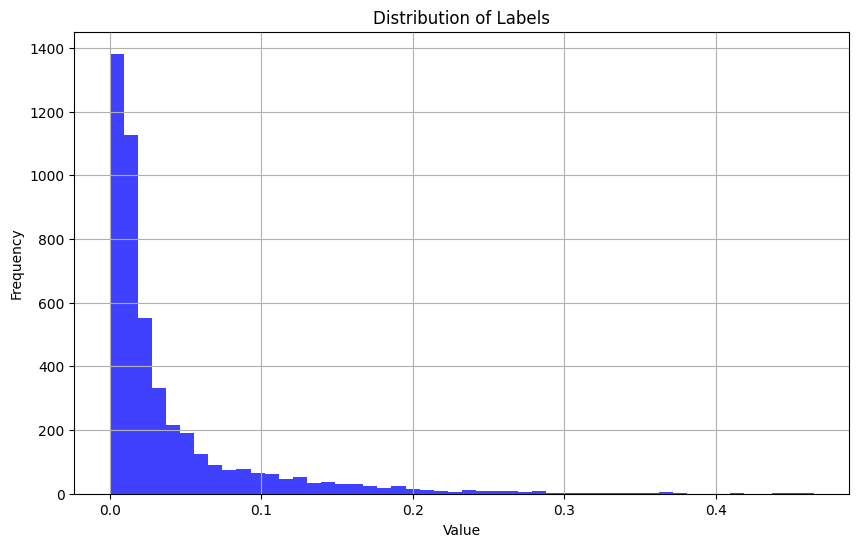

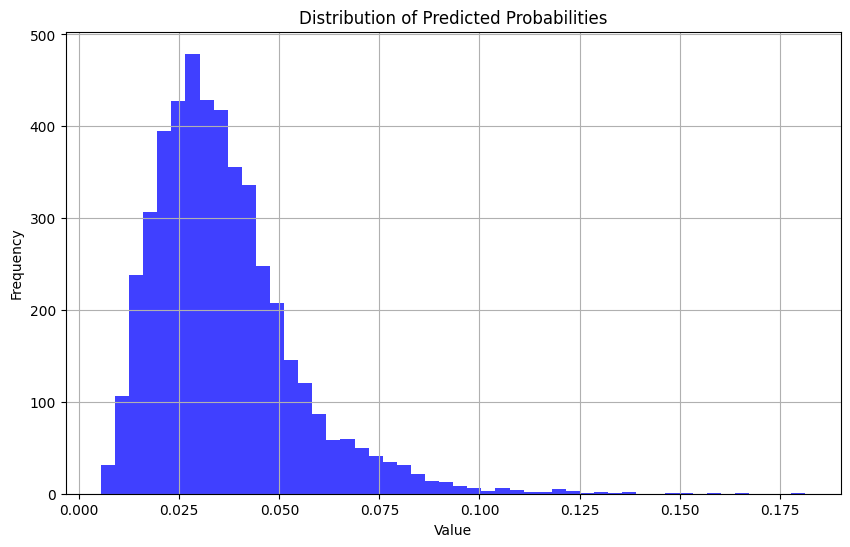

In [13]:
mae = mean_absolute_error(all_labels_mse, all_preds_mse)
mse = mean_squared_error(all_labels_mse, all_preds_mse)
r2 = r2_score(all_labels_mse, all_preds_mse)

print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"R² (coefficient of determination): {r2:.4f}")

plt.figure(figsize=(10, 6))
plt.hist(all_labels_mse, bins=50, alpha=0.75, color='blue')
plt.title('Distribution of Labels')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.grid()
plt.show()

plt.figure(figsize=(10, 6))
plt.hist(all_preds_mse, bins=50, alpha=0.75, color='blue')
plt.title('Distribution of Predicted Probabilities')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.grid()
plt.show()